# Fine-tune SAM on customized datasets (3D example)
1. Prepare original 3D images `data/FLARE22Train/` (Download link:https://zenodo.org/record/7860267) 
2. Run `pre_CT.py` for pre-processing. Expected output: `./data/Npz_files/CT_Abd-Gallbladder_`
3. Start this fine-tuning tutorial

In [1]:
# %% set up environment
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

2023-07-01 13:36:20.912376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 13:36:22.309321: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#%% create a dataset class to load npz data and return back image embeddings and ground truth
class NpzDataset(Dataset): 
    def __init__(self, data_root):
        self.data_root = data_root
        self.npz_files = sorted(os.listdir(self.data_root)) 
        self.npz_data = [np.load(join(data_root, f)) for f in self.npz_files]
        # this implementation is ugly but it works (and is also fast for feeding data to GPU) if your server has enough RAM
        # as an alternative, you can also use a list of npy files and load them one by one
        self.ori_gts = np.vstack([d['gts'] for d in self.npz_data])
        self.img_embeddings = np.vstack([d['img_embeddings'] for d in self.npz_data])
        print(f"{self.img_embeddings.shape=}, {self.ori_gts.shape=}")
    
    def __len__(self):
        return self.ori_gts.shape[0]

    def __getitem__(self, index):
        img_embed = self.img_embeddings[index]
        gt2D = self.ori_gts[index]
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = gt2D.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bboxes = np.array([x_min, y_min, x_max, y_max])
        # convert img embedding, mask, bounding box to torch tensor
        return torch.tensor(img_embed).float(), torch.tensor(gt2D[None, :,:]).long(), torch.tensor(bboxes).float()


In [3]:
# # %% test dataset class and dataloader
# npz_tr_path = 'medsam_data/2_files/MRI_brain-tumor/traib'
# demo_dataset = NpzDataset(npz_tr_path)
# demo_dataloader = DataLoader(demo_dataset, batch_size=8, shuffle=True)
# for img_embed, gt2D, bboxes in demo_dataloader:
#     # img_embed: (B, 256, 64, 64), gt2D: (B, 1, 256, 256), bboxes: (B, 4)
#     print(f"{img_embed.shape=}, {gt2D.shape=}, {bboxes.shape=}")
#     break

In [4]:
# %% set up model for fine-tuning 
# train data path
npz_tr_path = 'medsam_data/2_files/MRI_brain-tumor/train'
work_dir = './'
task_name = 'MRI_brain-tumor'
# prepare SAM model
model_type = 'vit_b'
checkpoint = 'SAM/sam_vit_b_01ec64.pth'
device = 'cuda:0'
model_save_path = join(work_dir, task_name)
os.makedirs(model_save_path, exist_ok=True)
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
sam_model.train()

# Set up the optimizer, hyperparameter tuning will improve performance here
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')


In [6]:
#%% train
num_epochs = 100
losses = []
best_loss = 1e10
train_dataset = NpzDataset(npz_tr_path)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (image_embedding, gt2D, boxes) in enumerate(tqdm(train_dataloader)):
        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            # convert box to 1024x1024 grid
            box_np = boxes.numpy()
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)
            # get prompt embeddings 
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        # predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          )

        loss = seg_loss(mask_predictions, gt2D.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))


self.img_embeddings.shape=(928, 256, 64, 64), self.ori_gts.shape=(928, 256, 256)


100%|██████████| 928/928 [00:40<00:00, 23.01it/s]


EPOCH: 0, Loss: 0.25851282519172825


100%|██████████| 928/928 [00:39<00:00, 23.57it/s]


EPOCH: 1, Loss: 0.2216254845663439


100%|██████████| 928/928 [00:38<00:00, 23.93it/s]


EPOCH: 2, Loss: 0.20905841760007823


100%|██████████| 928/928 [00:39<00:00, 23.56it/s]


EPOCH: 3, Loss: 0.1999962412809477


100%|██████████| 928/928 [00:39<00:00, 23.69it/s]


EPOCH: 4, Loss: 0.19096980588721613


100%|██████████| 928/928 [00:39<00:00, 23.24it/s]


EPOCH: 5, Loss: 0.18140137491359937


100%|██████████| 928/928 [00:39<00:00, 23.65it/s]


EPOCH: 6, Loss: 0.17811603537140797


100%|██████████| 928/928 [00:39<00:00, 23.69it/s]


EPOCH: 7, Loss: 0.17144031020558512


100%|██████████| 928/928 [00:39<00:00, 23.72it/s]


EPOCH: 8, Loss: 0.17249274813241558


100%|██████████| 928/928 [00:39<00:00, 23.66it/s]


EPOCH: 9, Loss: 0.16552744174080758


100%|██████████| 928/928 [00:39<00:00, 23.28it/s]


EPOCH: 10, Loss: 0.16047398712256966


100%|██████████| 928/928 [00:39<00:00, 23.78it/s]


EPOCH: 11, Loss: 0.15635462634128788


100%|██████████| 928/928 [00:39<00:00, 23.53it/s]


EPOCH: 12, Loss: 0.15506414450230852


100%|██████████| 928/928 [00:41<00:00, 22.63it/s]


EPOCH: 13, Loss: 0.15435866810614493


100%|██████████| 928/928 [00:40<00:00, 22.92it/s]


EPOCH: 14, Loss: 0.149290952481884


100%|██████████| 928/928 [00:40<00:00, 23.11it/s]


EPOCH: 15, Loss: 0.14954608112991563


100%|██████████| 928/928 [00:41<00:00, 22.49it/s]


EPOCH: 16, Loss: 0.14599948536359506


100%|██████████| 928/928 [00:41<00:00, 22.59it/s]


EPOCH: 17, Loss: 0.141463721840127


100%|██████████| 928/928 [00:44<00:00, 21.01it/s]


EPOCH: 18, Loss: 0.14175862388960622


100%|██████████| 928/928 [00:40<00:00, 22.66it/s]


EPOCH: 19, Loss: 0.13995901698562063


100%|██████████| 928/928 [00:40<00:00, 22.94it/s]


EPOCH: 20, Loss: 0.13688371128763324


100%|██████████| 928/928 [00:39<00:00, 23.43it/s]


EPOCH: 21, Loss: 0.13693676675150437


100%|██████████| 928/928 [00:39<00:00, 23.67it/s]


EPOCH: 22, Loss: 0.13602723150705956


100%|██████████| 928/928 [00:39<00:00, 23.60it/s]


EPOCH: 23, Loss: 0.13285730192447814


100%|██████████| 928/928 [00:39<00:00, 23.54it/s]


EPOCH: 24, Loss: 0.13155043305188194


100%|██████████| 928/928 [00:39<00:00, 23.76it/s]


EPOCH: 25, Loss: 0.12990712907322016


100%|██████████| 928/928 [00:39<00:00, 23.45it/s]


EPOCH: 26, Loss: 0.1266931773775218


100%|██████████| 928/928 [00:39<00:00, 23.77it/s]


EPOCH: 27, Loss: 0.12728805912351146


100%|██████████| 928/928 [00:39<00:00, 23.53it/s]


EPOCH: 28, Loss: 0.12536096701472838


100%|██████████| 928/928 [00:38<00:00, 24.25it/s]


EPOCH: 29, Loss: 0.12536756930613596


100%|██████████| 928/928 [00:39<00:00, 23.60it/s]


EPOCH: 30, Loss: 0.12266729783343137


100%|██████████| 928/928 [00:39<00:00, 23.45it/s]


EPOCH: 31, Loss: 0.12119853451542613


100%|██████████| 928/928 [00:39<00:00, 23.54it/s]


EPOCH: 32, Loss: 0.12096319628121913


100%|██████████| 928/928 [00:38<00:00, 24.39it/s]


EPOCH: 33, Loss: 0.11936026245773546


100%|██████████| 928/928 [00:39<00:00, 23.71it/s]


EPOCH: 34, Loss: 0.1196064091294586


100%|██████████| 928/928 [00:39<00:00, 23.59it/s]


EPOCH: 35, Loss: 0.11888924077104981


100%|██████████| 928/928 [00:39<00:00, 23.59it/s]


EPOCH: 36, Loss: 0.11785937152891354


100%|██████████| 928/928 [00:39<00:00, 23.66it/s]


EPOCH: 37, Loss: 0.1160178077130899


100%|██████████| 928/928 [00:39<00:00, 23.36it/s]


EPOCH: 38, Loss: 0.11888970622738589


100%|██████████| 928/928 [00:41<00:00, 22.54it/s]


EPOCH: 39, Loss: 0.11308413673244505


100%|██████████| 928/928 [00:39<00:00, 23.23it/s]


EPOCH: 40, Loss: 0.11314908071886245


100%|██████████| 928/928 [00:40<00:00, 22.84it/s]


EPOCH: 41, Loss: 0.11566005471969243


100%|██████████| 928/928 [00:39<00:00, 23.64it/s]


EPOCH: 42, Loss: 0.11158080432793083


100%|██████████| 928/928 [00:39<00:00, 23.64it/s]


EPOCH: 43, Loss: 0.11030435729309708


100%|██████████| 928/928 [00:41<00:00, 22.61it/s]


EPOCH: 44, Loss: 0.1105587798800669


100%|██████████| 928/928 [00:39<00:00, 23.74it/s]


EPOCH: 45, Loss: 0.10923984977934095


100%|██████████| 928/928 [00:39<00:00, 23.47it/s]


EPOCH: 46, Loss: 0.11239962921173441


100%|██████████| 928/928 [00:39<00:00, 23.35it/s]


EPOCH: 47, Loss: 0.10844097431937982


100%|██████████| 928/928 [00:39<00:00, 23.39it/s]


EPOCH: 48, Loss: 0.10814338086621018


100%|██████████| 928/928 [00:42<00:00, 21.99it/s]


EPOCH: 49, Loss: 0.10786982068737734


100%|██████████| 928/928 [00:41<00:00, 22.63it/s]


EPOCH: 50, Loss: 0.10672316119123046


100%|██████████| 928/928 [00:39<00:00, 23.27it/s]


EPOCH: 51, Loss: 0.10730298977453732


100%|██████████| 928/928 [00:39<00:00, 23.60it/s]


EPOCH: 52, Loss: 0.10568005058757696


100%|██████████| 928/928 [00:39<00:00, 23.68it/s]


EPOCH: 53, Loss: 0.10348075975492163


100%|██████████| 928/928 [00:39<00:00, 23.30it/s]


EPOCH: 54, Loss: 0.10321894066233465


100%|██████████| 928/928 [00:40<00:00, 22.79it/s]


EPOCH: 55, Loss: 0.10353970244735833


100%|██████████| 928/928 [00:39<00:00, 23.46it/s]


EPOCH: 56, Loss: 0.10190226994414674


100%|██████████| 928/928 [00:39<00:00, 23.70it/s]


EPOCH: 57, Loss: 0.10165931388912591


100%|██████████| 928/928 [00:39<00:00, 23.76it/s]


EPOCH: 58, Loss: 0.1024915008868986


100%|██████████| 928/928 [00:40<00:00, 23.09it/s]


EPOCH: 59, Loss: 0.10110445945908465


100%|██████████| 928/928 [00:41<00:00, 22.29it/s]


EPOCH: 60, Loss: 0.10119186770954564


100%|██████████| 928/928 [00:39<00:00, 23.60it/s]


EPOCH: 61, Loss: 0.10038121155550565


100%|██████████| 928/928 [00:39<00:00, 23.40it/s]


EPOCH: 62, Loss: 0.1001061194665738


100%|██████████| 928/928 [00:39<00:00, 23.74it/s]


EPOCH: 63, Loss: 0.09963189783991348


100%|██████████| 928/928 [00:39<00:00, 23.61it/s]


EPOCH: 64, Loss: 0.09808299925978001


100%|██████████| 928/928 [00:39<00:00, 23.60it/s]


EPOCH: 65, Loss: 0.09781539382286442


100%|██████████| 928/928 [00:42<00:00, 22.06it/s]


EPOCH: 66, Loss: 0.09689091414438225


100%|██████████| 928/928 [00:40<00:00, 22.79it/s]


EPOCH: 67, Loss: 0.09804189880303195


100%|██████████| 928/928 [00:37<00:00, 24.86it/s]


EPOCH: 68, Loss: 0.09635505347061568


100%|██████████| 928/928 [00:39<00:00, 23.48it/s]


EPOCH: 69, Loss: 0.09618019395404392


100%|██████████| 928/928 [00:39<00:00, 23.54it/s]


EPOCH: 70, Loss: 0.09610470643964271


100%|██████████| 928/928 [00:39<00:00, 23.49it/s]


EPOCH: 71, Loss: 0.09467712305124523


100%|██████████| 928/928 [00:39<00:00, 23.49it/s]


EPOCH: 72, Loss: 0.09471090338891121


100%|██████████| 928/928 [00:39<00:00, 23.55it/s]


EPOCH: 73, Loss: 0.09449123333187165


100%|██████████| 928/928 [00:39<00:00, 23.33it/s]


EPOCH: 74, Loss: 0.09415548609041216


100%|██████████| 928/928 [00:39<00:00, 23.79it/s]


EPOCH: 75, Loss: 0.09373727797690333


100%|██████████| 928/928 [00:39<00:00, 23.78it/s]


EPOCH: 76, Loss: 0.09244028740073228


100%|██████████| 928/928 [00:39<00:00, 23.68it/s]


EPOCH: 77, Loss: 0.09156260109770774


100%|██████████| 928/928 [00:39<00:00, 23.55it/s]


EPOCH: 78, Loss: 0.09262963335362324


100%|██████████| 928/928 [00:39<00:00, 23.65it/s]


EPOCH: 79, Loss: 0.09231461303262392


100%|██████████| 928/928 [00:39<00:00, 23.69it/s]


EPOCH: 80, Loss: 0.09158467018359945


100%|██████████| 928/928 [00:39<00:00, 23.68it/s]


EPOCH: 81, Loss: 0.09216203697291007


100%|██████████| 928/928 [00:39<00:00, 23.69it/s]


EPOCH: 82, Loss: 0.08972638794004982


100%|██████████| 928/928 [00:41<00:00, 22.53it/s]


EPOCH: 83, Loss: 0.08910520942208579


100%|██████████| 928/928 [00:43<00:00, 21.18it/s]


EPOCH: 84, Loss: 0.08911042460345914


100%|██████████| 928/928 [00:42<00:00, 21.91it/s]


EPOCH: 85, Loss: 0.09000817992540625


100%|██████████| 928/928 [00:40<00:00, 23.04it/s]


EPOCH: 86, Loss: 0.0896533646629852


100%|██████████| 928/928 [00:43<00:00, 21.12it/s]


EPOCH: 87, Loss: 0.08809144250011752


100%|██████████| 928/928 [00:39<00:00, 23.20it/s]


EPOCH: 88, Loss: 0.08937424350582152


100%|██████████| 928/928 [00:39<00:00, 23.55it/s]


EPOCH: 89, Loss: 0.08786652048300256


100%|██████████| 928/928 [00:39<00:00, 23.45it/s]


EPOCH: 90, Loss: 0.08833085468286064


100%|██████████| 928/928 [00:41<00:00, 22.43it/s]


EPOCH: 91, Loss: 0.08742201559751936


100%|██████████| 928/928 [00:38<00:00, 23.82it/s]


EPOCH: 92, Loss: 0.08886971102048921


100%|██████████| 928/928 [00:40<00:00, 22.96it/s]


EPOCH: 93, Loss: 0.08714749145662129


100%|██████████| 928/928 [00:39<00:00, 23.50it/s]


EPOCH: 94, Loss: 0.08633201414198809


100%|██████████| 928/928 [00:39<00:00, 23.59it/s]


EPOCH: 95, Loss: 0.08553003229626817


100%|██████████| 928/928 [00:39<00:00, 23.68it/s]


EPOCH: 96, Loss: 0.08618184232917547


100%|██████████| 928/928 [00:41<00:00, 22.58it/s]


EPOCH: 97, Loss: 0.08863171526786451


100%|██████████| 928/928 [00:41<00:00, 22.47it/s]


EPOCH: 98, Loss: 0.08478670887962514


100%|██████████| 928/928 [00:39<00:00, 23.21it/s]


EPOCH: 99, Loss: 0.08410295680117066


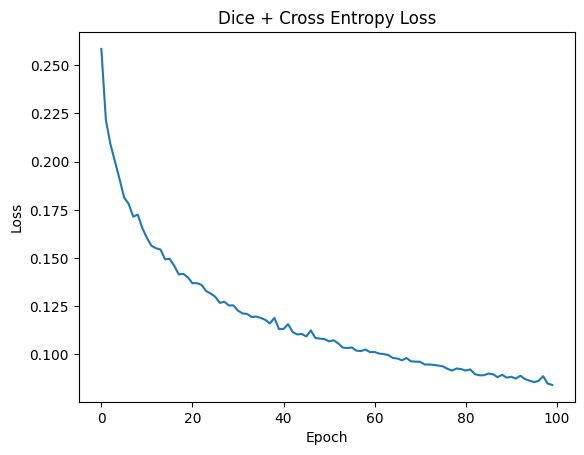

In [7]:
# plot loss
plt.plot(losses)
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
plt.savefig(join(model_save_path, 'train_loss.png'))
plt.close()

In [8]:
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)
npz_ts_path = 'medsam_data/2_files/MRI_brain-tumor/test'
test_npzs = sorted(os.listdir(npz_ts_path))
# random select a test case
npz_idx = np.random.randint(0, len(test_npzs))
npz = np.load(join(npz_ts_path, test_npzs[npz_idx]))
imgs = npz['imgs']
gts = npz['gts']

def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

ori_sam_segs = []
medsam_segs = []
bboxes = []
for img, gt in zip(imgs, gts):
    bbox = get_bbox_from_mask(gt)
    bboxes.append(bbox)
    # predict the segmentation mask using the original SAM model
    ori_sam_predictor.set_image(img)
    ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox, multimask_output=False)
    ori_sam_segs.append(ori_sam_seg[0])
    
    # predict the segmentation mask using the fine-tuned model
    H, W = img.shape[:2]
    resize_img = sam_trans.apply_image(img)
    resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
    input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
    with torch.no_grad():
        image_embedding = sam_model.image_encoder(input_image.to(device)) # (1, 256, 64, 64)
        # convert box to 1024x1024 grid
        bbox = sam_trans.apply_boxes(bbox, (H, W))
        box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
        if len(box_torch.shape) == 2:
            box_torch = box_torch[:, None, :] # (B, 1, 4)
        
        sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=None,
            boxes=box_torch,
            masks=None,
        )
        medsam_seg_prob, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
            )
        medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
        medsam_segs.append(medsam_seg)

In [9]:
#%% compute the DSC score
ori_sam_segs = np.stack(ori_sam_segs, axis=0)
medsam_segs = np.stack(medsam_segs, axis=0)
ori_sam_dsc = compute_dice_coefficient(gts>0, ori_sam_segs>0)
medsam_dsc = compute_dice_coefficient(gts>0, medsam_segs>0)
print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'MedSAM DSC: {:.4f}'.format(medsam_dsc))


Original SAM DSC: 0.5201 MedSAM DSC: 0.5911


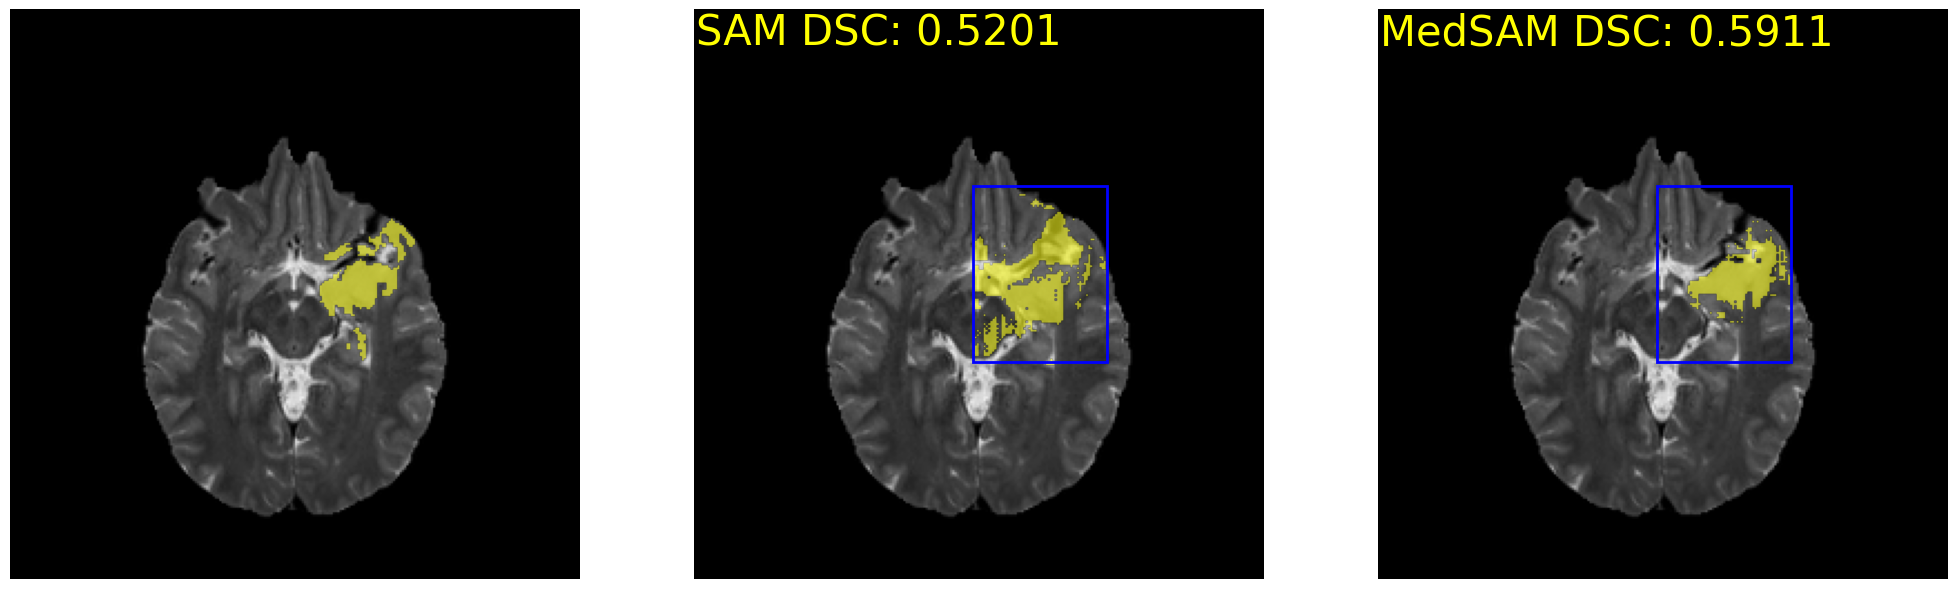

In [13]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    


img_id = int(imgs.shape[0]/2)  # np.random.randint(imgs.shape[0])
_, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].imshow(imgs[img_id])
show_mask(gts[img_id], axs[0])
# show_box(box_np[img_id], axs[0])
# axs[0].set_title('Mask with Tuned Model', fontsize=20)
axs[0].axis('off')

axs[1].imshow(imgs[img_id])
show_mask(ori_sam_segs[img_id], axs[1])
show_box(bboxes[img_id], axs[1])
# add text to image to show dice score
axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[1].set_title('Mask with Untuned Model', fontsize=20)
axs[1].axis('off')

axs[2].imshow(imgs[img_id])
show_mask(medsam_segs[img_id], axs[2])
show_box(bboxes[img_id], axs[2])
# add text to image to show dice score
axs[2].text(0.5, 0.5, 'MedSAM DSC: {:.4f}'.format(medsam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[2].set_title('Ground Truth', fontsize=20)
axs[2].axis('off')
plt.show()  
plt.subplots_adjust(wspace=0.01, hspace=0)
# save plot
# plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()


In [44]:
len(train_dataloader)

928